In [1]:
%matplotlib inline

import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

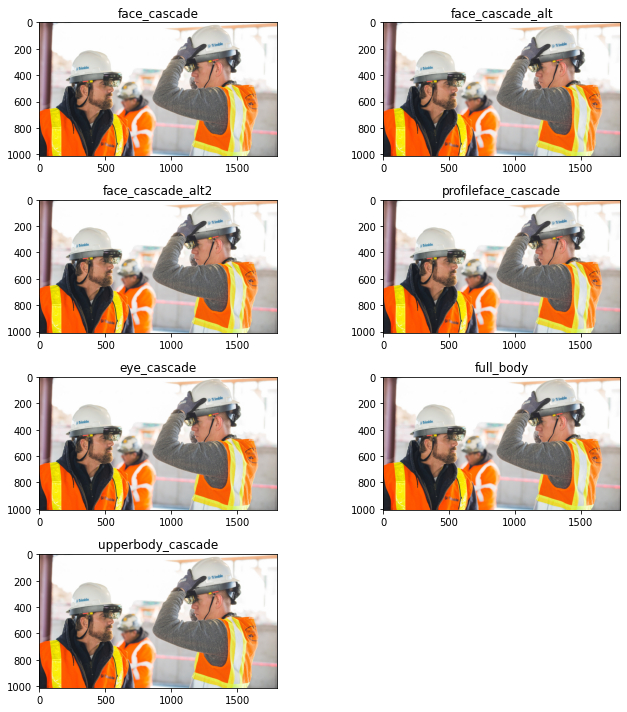

In [2]:
 # list of all the cascades available to us 
cascades_list = {
    'face_cascade': cv2.CascadeClassifier('./classifiers/haarcascade_frontalface_default.xml'),
    'face_cascade_alt':cv2.CascadeClassifier('./classifiers/haarcascade_frontalface_alt.xml'), 
    'face_cascade_alt2':cv2.CascadeClassifier('./classifiers/haarcascade_frontalface_alt2.xml'),
    'profileface_cascade':cv2.CascadeClassifier('./classifiers/haarcascade_profileface.xml'),
    'eye_cascade':cv2.CascadeClassifier('./classifiers/haarcascade_eye.xml'),
    'full_body':cv2.CascadeClassifier('./classifiers/haarcascade_fullbody.xml'),
    'upperbody_cascade':cv2.CascadeClassifier('./classifiers/haarcascade_upperbody.xml'),    
}

  
# create a function to detect face 
def detect_class(_img, cascade):
    '''
    Args:   _img: cv2.imread image type
            cascade: cv2.CascadeClassifier type
    Returns: img: cv2 image type
    ''' 
      
    img = _img.copy() 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      
    class_rect = cascade.detectMultiScale(img,scaleFactor = 1.3,minNeighbors = 5) 
      
    for (x, y, w, h) in class_rect: 
        cv2.rectangle(_img, (x, y),  
                      (x + w, y + h), (0, 255, 0), 10)
          
    return _img 
  
  
# Reading in the image and creating copies 
img = cv2.imread('./images/pos_1.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plotting the image and the classifiers we get
plt.figure(1, figsize=(10, 10))

for i, k in enumerate(cascades_list):
    face = detect_class(img.copy(), cascades_list[k])
    plt.subplot(421 + i)
    plt.title('{}'.format(k))
    plt.imshow(face)

plt.tight_layout()
plt.show()



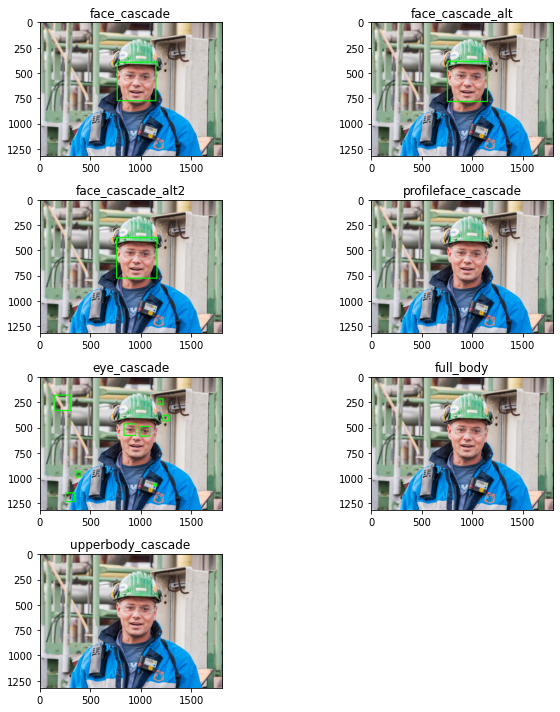

In [3]:
# Reading in the image and creating copies 
img = cv2.imread('./images/pos_641.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Using Classifiers
plt.figure(1, figsize=(10, 10))

for i, k in enumerate(cascades_list):
    face = detect_class(img.copy(), cascades_list[k])
    plt.subplot(421 + i)
    plt.title('{}'.format(k))
    plt.imshow(face)

plt.tight_layout()
plt.show()

In [4]:
from skinDetector import SkinDetector

def openCloseMask(mask, iterations = 2):
    # Create structural element
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))

    # perform opening and closing on the image until all the blobs have been removed for this 
    # particular mask and gaps have been filled
    newMask = mask.copy()
    for i in range(iterations):
        newMask = cv2.morphologyEx(newMask, cv2.MORPH_OPEN, shape)
        newMask = cv2.morphologyEx(newMask, cv2.MORPH_CLOSE, shape)

    return newMask

def getContours(binary_img):
    # find contours
    contours, hierarchy = cv2.findContours(binary_img, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

    # sort the contours by size
    newContours = sorted(contours, key=cv2.contourArea, reverse=True)
    return newContours

def getSkinMask(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    skinD = SkinDetector(image)
    skinD.findSkin() 

    skinMask = skinD.getMask()
    skinMask = openCloseMask(skinMask)  
    return skinMask

def preProcess(img):
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    smoothImg = cv2.fastNlMeansDenoising(image, h=6)   # noise removal
    return smoothImg

def combineBoundingBox(box1, box2):
    x = box1[0] if box1[0] < box2[0] else box2[0]
    y = box1[1] if box1[1] < box2[1] else box2[1]
    w = box1[2] if box1[2] > box2[2] else box2[2]
    h = box1[3] if box1[3] > box2[3] else box2[3]

    return (x, y, w, h)

def touchingRect(box1, box2):
    if box1[0] < box2[0] + box2[2] and \
    box1[0] + box1[2] > box2[0] and \
    box1[1] < box2[1] + box2[3] and \
    box1[1] + box1[3] > box2[1]:
        return True
    else:
        return False

def containsRect(box1, box2):
    x, y, w, h = box1
    x2, y2, w2, h2 = box2
    if ((x >= x2 and x <= x2+w2) and (y >= y2 and y <= y2+h2)) or \
         ((x <= x2 and x >= x2+w2) and (y <= y2 and y >= y2+h2)):
        return True

def getFaces(img, skinMask):
    image = img.copy()
    contours = getContours(skinMask)

    newRects = []
    largestArea = cv2.contourArea(contours[0])

    # Discard irrelevant contours (5x smaller than the biggest area contours)
    for c in range(len(contours)):
        area = cv2.contourArea(contours[c])
        if area > largestArea * 0.20:
            newRects.append(cv2.boundingRect(contours[c]))
            # cv2.rectangle(image, cv2.boundingRect(contours[c]), color=(0,255,155), thickness=4)
                
    # Merge boxes into one
    mergedRects = []
    for i in range(len(newRects)):
        if i+1 <= len(newRects):
            for j in range(i+1, len(newRects)):
                if touchingRect(newRects[i], newRects[j]) == True:
                    newBox = combineBoundingBox(newRects[i], newRects[j])
                    if not newBox in newRects:
                        # cv2.rectangle(image, newBox, color=(0,255,255), thickness=4) # Comment this in final
                        mergedRects.append(newBox)
                    newRects.append(newBox)

    # nullify rect if its a child of another rect
    for i in range(len(mergedRects)):
        if i+1 <= len(mergedRects):
            for j in range(i+1, len(mergedRects)):
                if containsRect(mergedRects[i], mergedRects[j]):
                    area = mergedRects[i][2] * mergedRects[i][3]
                    area1 = mergedRects[j][2] * mergedRects[j][3]
                    if area > area1:
                        mergedRects[j] = (0,0,0,0)
                    elif area1 > area: 
                        mergedRects[i] = (0,0,0,0)


    # If there were no merged boxes then fallback to base face rects
    if len(mergedRects) == 0:
        mergedRects = newRects


    # remove any rectangles directly below
    for i in range(len(mergedRects)):
        if i+1 <= len(mergedRects):
            for j in range(i+1, len(mergedRects)):
                curr = mergedRects[i]
                comp = mergedRects[j]

                if comp[0] >= curr[0] and comp[0]+comp[2] <= curr[0]+curr[2] and comp[1] >= curr[1]:
                    mergedRects[j] = (0,0,0,0)


    faces = []
    for r in mergedRects: # final array with non empty values
        if r != (0,0,0,0):
            # get the coordinates of the rectangle
            x, y, w, h = r
            # calculate coordinates of top-left corner
            # Y = y - 1.2*h and if it going outside the image, it takes a value of 0
            newY = y-int(1.2*h)
            if newY < 0:
                newY = 0
            # X =  x - w - w*0.2 and if it going outside the image, it takes a value of 0
            left = x - int(w*0.2)
            if left < 0:
                left = 0
            
            width = w + int(w*0.5)
            height = int(2.2*h)
            
            newFace = (left,newY,width,height)
            # cv2.rectangle(image, newFace, color=(0,255,255), thickness=4)
            faces.append(newFace)
                    
    # plt.imshow(image)
    # plt.show()
    return faces

def processHelmet(img):
    # convert to hsv
    h, w = img.shape[:2]
    area = h * w

    hsvImage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    helmetColors = [
        ((56,3,133), (116,255,241)), # green
        ((15,0,180), (115,37,236)) # white
    ]

    isHelmet = False
    for color in helmetColors:
        try: 
            lower, upper = color

            helmet_mask = cv2.inRange(hsvImage,lower,upper)
            finalMask = openCloseMask(helmet_mask, 4)

            rect = cv2.boundingRect(getContours(finalMask)[0]) + finalMask.std()
            helmetArea = rect[2] * rect[3]

            percentage = float(helmetArea / area) * 100

            # print(percentage)
            # plt.imshow(finalMask, 'gray')
            # plt.show()

            if percentage >= 39.0:
                isHelmet = True
        except:
            ''
    return isHelmet

def getHelmets(img, skinMask, faces):
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    roi_img = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(skinMask))
    roi_img[np.all(roi_img >= 250, axis=2)] = 0
    roi_img[np.all(roi_img <= 150, axis=2)] = 0
    for f in faces:
        faceArea = roi_img[
            f[1]:f[1]+f[3],
            f[0]:f[0]+f[2],
        ]

        isHelmet = processHelmet(faceArea)

        if isHelmet == True:
            cv2.rectangle(image, f, color=(0,255,0), thickness=6)
        else:
            cv2.rectangle(image, f, color=(255,0,0), thickness=6)
            
        # plt.imshow(faceArea)
        # plt.show()

    return image

def process(img):
    preImg = preProcess(img)
    skinMask = getSkinMask(preImg)
    foundFaces = getFaces(preImg, skinMask)
    helmetImg = getHelmets(img, skinMask, foundFaces)

    plt.imshow(helmetImg)
    plt.show()


img = cv2.imread('./images/pos_1.jpg')
Img = process(img)
img = cv2.imread('./images/pos_641.jpg')
Img = process(img)
img = cv2.imread('./images/pos_1003.jpg')
Img = process(img)
img = cv2.imread('./images/neg_14391.jpg')
Img = process(img)
img = cv2.imread('./images/pos_823.jpg')
Img = process(img)


AttributeError: 'SkinDetector' object has no attribute 'find_skin'